# Sieci Neuronowe - kolokwium zaliczeniowe
### WSB-NLU, 2023-2024

Andrzej Kocielski

## Do zrobienia
Rozwiązanie zawierać ma elementy:
- wczytanie danych i krótki opis (5 pkt)
- przygotowanie danych do uczenia (5 pkt)
- trening sieci z komentarzem (5 pkt)
- tuning parametrów i ocena rozwiązania z komentarzem (5 pkt)
- porównanie z innym modelem ML (5 pkt), drugim innym modelem (+3pkt*)

Uwaga. Każdą fazę należy wydzielić i pokazać nie tylko kod, ale i screeny z testami działania.

Fragmenty kodu wykorzystane wcześniej do rozwiązania zadań na laboratoriach.

In [1]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

2024-02-12 22:12:51.153562: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-12 22:12:51.194775: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 22:12:51.194824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 22:12:51.195985: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 22:12:51.201799: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-12 22:12:51.202473: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [9]:
# Source of dataset: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification/data
# The whole dataset consists of  5631 images with jpg format, split into four categories (classes): 
# cloudy (1500 images), desert (1131 images), green area (1500 images) and water (1500images).

# Path to the dataset 
dataset_path = 'satelite_dataset'

# The file names are inconsistent, so below we change their names to have a format like class_0001.jpg, class_0002.jpg, and so on
def rename_files_with_numbered_format(folder_path):
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            counter = 1
            for filename in os.listdir(class_path):
                if filename.endswith('.jpg'):
                    old_path = os.path.join(class_path, filename)
                    new_filename = f"{class_name}-{counter:04d}.jpg"
                    new_path = os.path.join(class_path, new_filename)
                    os.rename(old_path, new_path)
                    counter += 1

# Rename files in the dataset folder
rename_files_with_numbered_format(dataset_path)

In [14]:
# Loading the data

# Function to extract class from filename
def extract_class_from_filename(filename):
    # return filename.split('_')[0]
    # Extract the class name from the immediate parent directory
    class_name = os.path.basename(os.path.dirname(filename))
    return class_name

# Application of ImageDataGenerator to load and preprocess images (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
datagen = None # reset if exists
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2) # 20% validation subset

# Image resize to improve perfomance (no GPU on my machine!)
image_height, image_width = 64, 64

# Create separate training and validation generators
print(f'Training subset:', end=' ')
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(image_height, image_width),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

print(f'Validation subset:', end=' ')
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(image_height, image_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Display the class indices
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
print(f'Terrain classes with corresponding id: {class_indices}')

# Manually apply label_func to convert categorical labels to one-hot encoded labels
def label_func(filename):
    class_name = extract_class_from_filename(filename)
    return tf.keras.utils.to_categorical(class_indices[class_name], len(class_indices))

# Example: Setting labels for the training set
train_labels = [label_func(filename) for filename in train_generator.filenames]

# Example: Setting labels for the validation set
validation_labels = [label_func(filename) for filename in validation_generator.filenames]

Training subset: Found 2275 images belonging to 4 classes.


Validation subset: Found 567 images belonging to 4 classes.
Terrain classes with corresponding id: {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


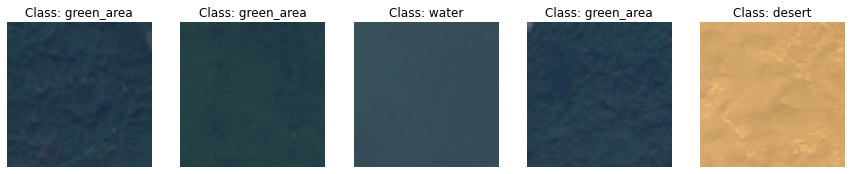

In [15]:

# Get a batch of images and labels from the training set
sample_images, sample_labels = train_generator[1]

# Select a random subset of images
sample_size = 5  
random_indices = random.sample(range(len(sample_images)), sample_size)

# Display the randomly selected images with their corresponding labels
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, sample_size, i + 1)
    plt.imshow(sample_images[idx])
    plt.title(f'Class: {class_names[tf.argmax(sample_labels[idx]).numpy()]}')
    plt.axis('off')

plt.show()

## A simple deep neural network (for trial)

In [16]:
# Create a sequential model
model = models.Sequential()

# Convolutional Layer 1
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 2
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 3
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output to feed into densely connected layers
model.add(layers.Flatten())

# Fully Connected (Dense) Layer 1
model.add(layers.Dense(64, activation='relu'))

# Output layer with softmax activation for multiclass classification
model.add(layers.Dense(len(class_names), activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 32)         

In [17]:
# Training the initial model (for trial)
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
72/72 [==============================] - 6s 65ms/step - loss: 0.7414 - accuracy: 0.6255 - val_loss: 0.5029 - val_accuracy: 0.7090
Epoch 2/10
72/72 [==============================] - 5s 66ms/step - loss: 0.4982 - accuracy: 0.7411 - val_loss: 0.4697 - val_accuracy: 0.7019
Epoch 3/10
72/72 [==============================] - 6s 81ms/step - loss: 0.4272 - accuracy: 0.8022 - val_loss: 0.4193 - val_accuracy: 0.8307
Epoch 4/10
72/72 [==============================] - 6s 77ms/step - loss: 0.3822 - accuracy: 0.8352 - val_loss: 0.3762 - val_accuracy: 0.8466
Epoch 5/10
72/72 [==============================] - 6s 83ms/step - loss: 0.3870 - accuracy: 0.8457 - val_loss: 0.4014 - val_accuracy: 0.8148
Epoch 6/10
72/72 [==============================] - 6s 85ms/step - loss: 0.3546 - accuracy: 0.8598 - val_loss: 0.4084 - val_accuracy: 0.8236
Epoch 7/10
72/72 [==============================] - 9s 129ms/step - loss: 0.3563 - accuracy: 0.8585 - val_loss: 0.3809 - val_accuracy: 0.8360
Epoch 8/10
7

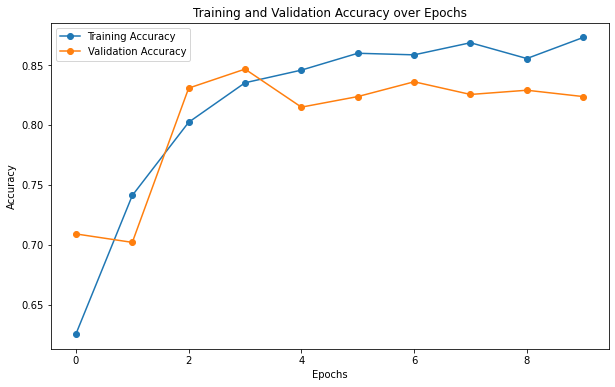

In [18]:
# Plotting training progress
plt.figure(figsize=(10, 6))

# Plot training accuracy
plt.plot(model.history.history['accuracy'], label='Training Accuracy', marker='o')

# Plot validation accuracy
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', marker='o')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Hyperparameters tuning

In [27]:
# Define hyperparameters to tune - tuning parameters limited here due to long computation time
num_layers_list = [3]#, 4, 5] 
num_nodes_list = [32, 48]#, 64, 96, 128]
activation_functions = ['relu']#, 'sigmoid']
epochs_list = [6]#, 10, 20]

# Function to build and train a model with given hyperparameters
def build_and_train_model(num_layers, num_nodes, activation_function, epochs):
    model = models.Sequential()
    
    # Convolutional Layers
    model.add(layers.Conv2D(24, (3, 3), activation=activation_function, input_shape=(image_height, image_width, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    for _ in range(num_layers - 1):
        model.add(layers.Conv2D(32, (3, 3), activation=activation_function))
        model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output to feed into densely connected layers
    model.add(layers.Flatten())

    # Dense Layers
    model.add(layers.Dense(num_nodes, activation=activation_function))
    
    # Output layer
    model.add(layers.Dense(len(class_names), activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, verbose=0)
    
    return model, history

# Iterate through hyperparameters and train models
results = []

for num_layers in num_layers_list:
    for num_nodes in num_nodes_list:
        for activation_function in activation_functions:
            for epochs in epochs_list:
                print(f'Activation function: {activation_function}, Layers: {num_layers}, Nodes: {num_nodes}, Epochs: {epochs}')
                # Build and train the model
                model, history = build_and_train_model(num_layers, num_nodes, activation_function, epochs)
                
                # Evaluate the model on the validation set
                _, val_accuracy = model.evaluate(validation_generator)
                
                # Store the results
                results.append({
                    'num_layers': num_layers,
                    'num_nodes': num_nodes,
                    'activation_function': activation_function,
                    'epochs': epochs,
                    'val_accuracy': val_accuracy
                })
    print("___")

# Print and analyze the results
# for result in results:
#     print(result)
results_df = pd.DataFrame(results)
print(results_df)
print()

# Choose the best hyperparameters based on your analysis
best_hyperparameters = max(results, key=lambda x: x['val_accuracy'])
print("Best Hyperparameters:", best_hyperparameters)

--> Activation funtion: relu, Layers: 3, Nodes: 32, Epochs: 6


KeyboardInterrupt: 

## References:
- [https://www.vortexa.com/insights/technology/satellite-images-object-detection/](https://www.vortexa.com/insights/technology/satellite-images-object-detection/)


___
Andrzej Kocielski, 2024